Goal - convenience functions to parse HA data into useful format for data science. Consider creating a class to hold the data.
SQLAlchemy is used in this notebook but other suitable libraries are available.

http://nbviewer.jupyter.org/github/home-assistant/home-assistant-notebooks/blob/master/DataExploration-1/DataExploration-1.ipynb

http://www.sqlalchemy.org/

https://www.dataquest.io/blog/images/cheat-sheets/pandas-cheat-sheet.pdf

https://chrisalbon.com/ Useful ref

26-12-2016: updated to use Google cloud data as MySQL server appears to have stopped several days ago

8-1-2018: Query local db on synology (copied to Mac, 4 GB) as has 6 months of data

In [1]:
%matplotlib inline
from datetime import datetime
from sqlalchemy import create_engine, text
import json
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt

In [2]:
def load_url(filename):
    """Convenience for loading a url from a json file."""
    try:
        with open(filename, 'r') as fp:
            url = json.load(fp)
    except Exception as e:
        print('Failed to load url')
        url = None
    return url['url']

Some helper functions for parsing HA data

In [3]:
def time_category(dtObj):
    """Return a time category, bed, home, work, given a datetime object dtObj."""
    if 9 <= dtObj.hour <= 17:
        return 'daytime'
    elif 5 <= dtObj.hour < 9:
        return 'morning'
    elif 17 < dtObj.hour < 23:
        return 'evening'
    else:
        return 'night'

In [4]:
def is_weekday(dtObj):
    """Check a datetime object dtObj is a weekday"""
    if dtObj.weekday() < 5:
        return True
    else:
        return False

In [5]:
def isfloat(value):
    """Check if string can be parsed to a float."""
    try:
        float(value)
        return True
    except ValueError:
        return False

isfloat('23.6')

True

In [6]:
def parse_state(value):
    """Check if state can be parsed to a float."""
    try:
        float(value)
        return float(value)
    except ValueError:
        return value

val = parse_state('23.6')

In [7]:
parse_state('foo')

'foo'

In [8]:
def binary_state(value):
    """Return a binary for the state of binary sensors"""
    if  value == 'on':
        return True
    elif value == 'off':
        return False
    else:
        return float('nan')

print(binary_state('on'))
print(binary_state('off'))
print(binary_state('foo'))

True
False
nan


In [9]:
def rename_entity(entity_id):
    """Takes an entity_if of form sensor.name and returns name."""
    return entity_id.split('.')[1]

rename_entity('sensor.bme680humidity')

'bme680humidity'

Conveninece to query and filter list of entities

In [10]:
def query_entities(*args, **kwargs):
    """Takes a query term or terms and returns a list of entities satisfying the term. 
    Additionally apply a single filter term. 
    Example usage = query_entities('temperature', 'light', filter='sensor)"""
    query_results = [entity for entity in entity_list if any(query in entity for query in args)] 
    if kwargs['filter']:
        filtered_resaults = [entity for entity in query_results if kwargs['filter'] in entity]
        return filtered_resaults
    else:
        return query_results

Convenience function for checking a state. This is incredibly slow when applied to large data frames. Better approach is place data on time index and fill.

In [11]:
def state_at_time(df, dtObj):
    """Check the last registered state at some time using asof.
    Passed df needs to be time indexed and should only include the entitiy_id of interest."""
    found_index = df.index.asof(dtObj)     # Find the closest index asof time test_time
    if pd.isnull(found_index):             # If dtObj is before the first index of dt, will return NaT
        return float('nan')
    else:
        state = df.loc[found_index]['state']      # Get the state at the found_index
        return state

## Fetch the states data

DB is approx 4 Gb

In [12]:
db_path = 'Users/robincole/Documents/Home-assistant_database/home-assistant_v2.db'

In [13]:
DB_URL = 'sqlite:////' + db_path

In [14]:
engine = create_engine(DB_URL)

In [15]:
%%time
entity_id_list =  list(engine.execute("SELECT entity_id, COUNT(*) FROM states \
GROUP BY entity_id ORDER by 2 DESC"))

CPU times: user 545 ms, sys: 2.61 s, total: 3.16 s
Wall time: 13.9 s


In [16]:
len(entity_id_list)

261

In [17]:
entity_list = list(zip(*entity_id_list))[0]

In [18]:
entity_list[0:5]

('automation.update_indoor_temperature',
 'sun.sun',
 'sensor.time__date',
 'sensor.date__time',
 'sensor.time')

Select all state data for last X days, store in a single dataframe for convenience

In [19]:
%%time
# query to pull all rows form the states table where last_changed field is on \
# or after the date_filter value
#stmt = text("SELECT * FROM states where last_changed>=:date_filter")
stmt = text("""SELECT domain, entity_id, state, last_changed FROM states WHERE NOT state='unknown' """)

# bind parameters to the stmt value, specifying the date_filter to be 10 days \
# before today
#stmt = stmt.bindparams(date_filter=datetime.now()-timedelta(days=100))

# execute the SQL statement
allquery = engine.execute(stmt)

# get rows from query into a pandas dataframe
allqueryDF = pd.DataFrame(allquery.fetchall())

CPU times: user 7.53 s, sys: 14 s, total: 21.5 s
Wall time: 1min 6s


In [20]:
allqueryDF.shape

(2164542, 4)

In [21]:
print("The dataframse size on disk is {} MB".format(allqueryDF.values.nbytes/1e6))

The dataframse size on disk is 69.265344 MB


Name the columns, need to look into the difference between last_changed & last_updated

In [22]:
allqueryDF.columns = ['domain', 'entity', 'state', 'last_changed']

In [23]:
allqueryDF.head()

,domain,entity,state,last_changed
0,sun,sun.sun,above_horizon,2017-07-11 10:28:16.677853
1,zone,zone.work,zoning,2017-07-11 10:28:16.679145
2,zone,zone.home,zoning,2017-07-11 10:28:16.680212
3,zone,zone.redhill,zoning,2017-07-11 10:28:16.681305
4,zone,zone.waterloo,zoning,2017-07-11 10:28:16.682356


Lets copy the master df in case we want to recover the original.
Also we would like to know if states are numerical or not

In [24]:
df = allqueryDF

In [25]:
df['numerical'] = df['state'].apply(lambda x: isfloat(x)) 

In [26]:
#allqueryDF['state'] = allqueryDF['state'].apply(lambda state: parse_state(state))  # Lets convert the numericals into floats 

In [27]:
df.tail()

,domain,entity,state,last_changed,numerical
2164537,sensor,sensor.bme680humidity,44.61,2017-10-30 05:42:12.800189,True
2164538,sensor,sensor.bme680air_qual,98.08,2017-10-30 05:42:12.867009,True
2164539,sensor,sensor.bme680humidity,44.57,2017-10-30 05:42:13.777365,True
2164540,sensor,sensor.bme680pressure,1032.95,2017-10-30 05:42:13.797559,True
2164541,sensor,sensor.bme680air_qual,98.1,2017-10-30 05:42:13.808671,True


Convert to multi-index

In [28]:
df = df[['domain', 'entity', 'last_changed', 'numerical', 'state']].set_index(['domain', 'entity', 'numerical', 'last_changed'])
df.head()

state
domain entity        numerical last_changed                             
sun    sun.sun       False     2017-07-11 10:28:16.677853  above_horizon
zone   zone.work     False     2017-07-11 10:28:16.679145         zoning
       zone.home     False     2017-07-11 10:28:16.680212         zoning
       zone.redhill  False     2017-07-11 10:28:16.681305         zoning
       zone.waterloo False     2017-07-11 10:28:16.682356         zoning

## Numerical data
lets do a query for numerical sensor

In [29]:
num_sensors_df = df.query('domain == "sensor" & numerical == True')
num_sensors_df['state'] = num_sensors_df['state'].astype('float')
num_sensors_df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


state
domain entity                                   numerical last_changed                     
sensor sensor.next_train_to_wat                 True      2017-07-11 10:28:17.666803   76.0
       sensor.next_bus_to_new_malden            True      2017-07-11 10:28:17.707308   73.0
       sensor.darksky_sensor_temperature        True      2017-07-11 10:28:18.327575   18.8
       sensor.darksky_sensor_precip_probability True      2017-07-11 10:28:18.333331   10.0
       sensor.iphone_battery_level              True      2017-07-11 10:28:19.729009   77.0

In [30]:
num_sensors_list = list(num_sensors_df.index.get_level_values('entity').unique())
print(len(num_sensors_list))
num_sensors_list

52


['sensor.next_train_to_wat',
 'sensor.next_bus_to_new_malden',
 'sensor.darksky_sensor_temperature',
 'sensor.darksky_sensor_precip_probability',
 'sensor.iphone_battery_level',
 'sensor.robins_iphone_battery_level',
 'sensor.blink_blink_camera_percy_temperature',
 'sensor.blink_blink_camera_percy_notifications',
 'sensor.next_train_in',
 'sensor.home_to_waterloo',
 'sensor.work_to_home',
 'sensor.home_to_work',
 'sensor.network_up',
 'sensor.cpu_load_total',
 'sensor.volume_used_volume_1',
 'sensor.memory_usage_real',
 'sensor.speedtest_download',
 'sensor.next_bus_to_wantage',
 'sensor.next_train_to_wim',
 'sensor.next_train_to_csn',
 'sensor.next_bus_in',
 'sensor.hall_light_sensor',
 'sensor.hall_temperature',
 'sensor.living_room_temperature',
 'sensor.living_room_light_sensor',
 'sensor.bedroom_light_sensor',
 'sensor.bedroom_temperature',
 'sensor.remote_living_room_button',
 'sensor.living_room_remote_status',
 'sensor.average_indoor_temp',
 'sensor.max_sensor',
 'sensor.mean_t

Lets do a pivot to get sensors in columns to make plotting convenient. Lets also forward fill the data

In [31]:
num_sensors_df = num_sensors_df.pivot_table(index='last_changed', columns='entity', values='state')
num_sensors_df = num_sensors_df.fillna(method='ffill')
num_sensors_df = num_sensors_df.dropna() # drop any remaining nan
num_sensors_df.index = pd.to_datetime(num_sensors_df.index)

In [32]:
num_sensors_df.head()

entity,sensor.average_indoor_temp,sensor.bedroom_light_sensor,sensor.bedroom_temperature,sensor.blink_blink_camera_percy_notifications,sensor.blink_blink_camera_percy_temperature,sensor.bme680air_qual,sensor.bme680humidity,sensor.bme680pressure,sensor.bme680temperature,sensor.breaches_fredallcardgmailcom,...,sensor.next_train_to_wat,sensor.next_train_to_wim,sensor.remote_living_room_button,sensor.robins_iphone_battery_level,sensor.speedtest_download,sensor.volume_used_volume_1,sensor.wipy_humidity,sensor.wipy_memory,sensor.wipy_temperature,sensor.work_to_home
last_changed,,,,,,,,,,,,,,,,,,,,,
2017-10-28 06:48:00.143377,20.2,15621.0,18.89,1.0,21.0,98.51,43.58,1033.93,21.07,0.0,...,1125.0,87.0,1002.0,94.0,36.37,20.7,14.0,38112.0,32.0,25.0
2017-10-28 06:48:01.060922,20.2,15621.0,18.89,1.0,21.0,98.51,43.50,1033.93,21.07,0.0,...,1125.0,87.0,1002.0,94.0,36.37,20.7,14.0,38112.0,32.0,25.0
2017-10-28 06:48:01.069416,20.2,15621.0,18.89,1.0,21.0,98.51,43.50,1033.93,21.06,0.0,...,1125.0,87.0,1002.0,94.0,36.37,20.7,14.0,38112.0,32.0,25.0
2017-10-28 06:48:01.076784,20.2,15621.0,18.89,1.0,21.0,98.51,43.50,1033.95,21.06,0.0,...,1125.0,87.0,1002.0,94.0,36.37,20.7,14.0,38112.0,32.0,25.0
2017-10-28 06:48:01.079950,20.2,15621.0,18.89,1.0,21.0,98.54,43.50,1033.95,21.06,0.0,...,1125.0,87.0,1002.0,94.0,36.37,20.7,14.0,38112.0,32.0,25.0


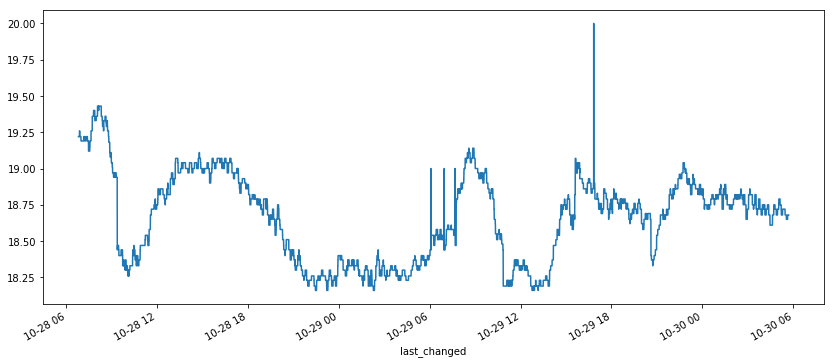

In [33]:
height=6
width=14

num_sensors_df['sensor.mean_temperature'].plot(figsize=(width, height))

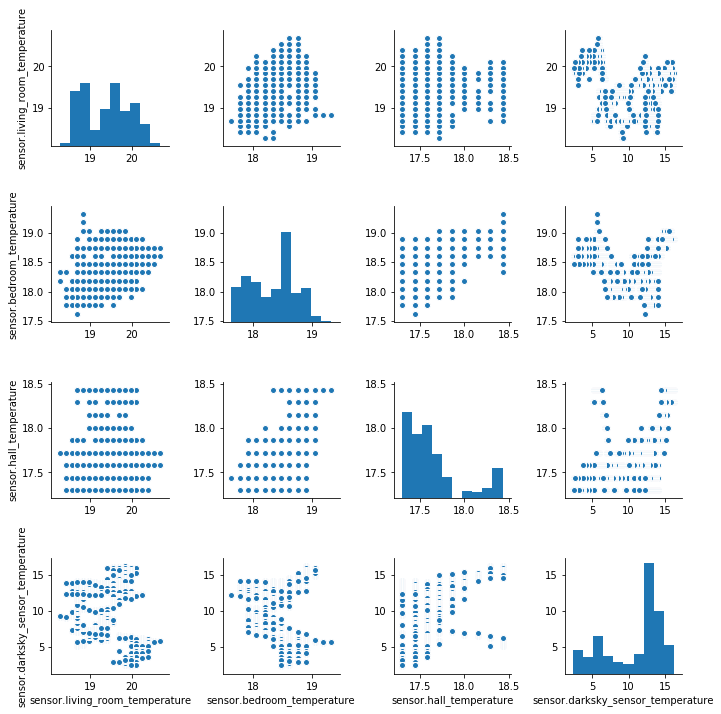

In [34]:
sns_plot = sns.pairplot(num_sensors_df[['sensor.living_room_temperature',
'sensor.bedroom_temperature',
'sensor.hall_temperature', 
'sensor.darksky_sensor_temperature']]);

sns_plot.savefig("pairplot.png")

### Motion at home sensor
Lets focus on the binary_sensor.motion_at_home which is a sensor that indicates if there is any activity at home. In the pivot_table apply np.min to prevent np.mean (the default) from returning 0.5 in some cases (why is this?)

In [35]:
binary_sensors_df = df.query('domain == "binary_sensor"')
binary_sensors_list = list(binary_sensors_df.index.get_level_values('entity').unique())
print(len(binary_sensors_list))
binary_sensors_list

10


['binary_sensor.workday_sensor',
 'binary_sensor.blink_blink_camera_percy_motion_enabled',
 'binary_sensor.living_room_nest_protect_online',
 'binary_sensor.blink_armed_status',
 'binary_sensor.hall_motion_sensor',
 'binary_sensor.bedroom_motion_sensor',
 'binary_sensor.living_room_motion_sensor',
 'binary_sensor.motion_at_home',
 'binary_sensor.bayesianbinary',
 'binary_sensor.in_bed_bayesian']

In [36]:
binary_sensors_df['state'] = binary_sensors_df['state'].apply(lambda x: binary_state(x)) # Binarise

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
binary_sensors_df = binary_sensors_df.pivot_table(index='last_changed', columns='entity', values='state')

In [38]:
binary_sensors_df.head()

entity,binary_sensor.bayesianbinary,binary_sensor.bedroom_motion_sensor,binary_sensor.blink_armed_status,binary_sensor.blink_blink_camera_percy_motion_enabled,binary_sensor.hall_motion_sensor,binary_sensor.in_bed_bayesian,binary_sensor.living_room_motion_sensor,binary_sensor.living_room_nest_protect_online,binary_sensor.motion_at_home,binary_sensor.workday_sensor
last_changed,,,,,,,,,,
2017-07-11 10:28:17.460144,None,None,None,None,None,None,None,None,None,True
2017-07-11 10:28:18.898022,None,None,None,False,None,None,None,None,None,None
2017-07-11 10:28:18.951186,None,None,None,None,None,None,None,True,None,None
2017-07-11 10:28:19.047789,None,None,False,None,None,None,None,None,None,None
2017-07-11 12:00:03.023620,None,None,None,True,None,None,None,None,None,None


In [39]:
binary_sensors_df = binary_sensors_df.fillna(method='ffill')
binary_sensors_df = binary_sensors_df.dropna() # drop any remaining nan

Lets get only the motion sensor and put in a dataframe

In [40]:
motion_df = binary_sensors_df["binary_sensor.motion_at_home"].to_frame() 

In [41]:
motion_df.index = pd.to_datetime(motion_df.index)

#### Create some features
Lets get the weekday

In [42]:
motion_df['weekday'] = motion_df.index.weekday_name

In [43]:
motion_df['time'] = motion_df.index.time

In [44]:
motion_df['is_weekday'] = motion_df.index.map(lambda x: is_weekday(x))

In [45]:
motion_df = motion_df[motion_df['binary_sensor.motion_at_home'] == True] # Keep only true detection events

In [46]:
motion_df['time_category'] = motion_df.index.map(lambda x: time_category(x))

In [47]:
motion_df.head()

,binary_sensor.motion_at_home,weekday,time,is_weekday,time_category
last_changed,,,,,
2017-09-17 06:22:30.952383,True,Sunday,06:22:30.952383,False,morning
2017-09-17 06:24:14.926184,True,Sunday,06:24:14.926184,False,morning
2017-09-17 06:26:49.048484,True,Sunday,06:26:49.048484,False,morning
2017-09-17 06:27:07.053517,True,Sunday,06:27:07.053517,False,morning
2017-09-17 06:28:08.058714,True,Sunday,06:28:08.058714,False,morning


#### Analysis of motion data
Try a facet grid to represent data https://seaborn.pydata.org/generated/seaborn.FacetGrid.html?highlight=facet#seaborn.FacetGrid
Lets see if there is more motion at home on weekends.

In [48]:
motion_df['binary_sensor.motion_at_home'].groupby(motion_df['is_weekday']).describe()['count']

is_weekday
False    1799
True     2944
Name: count, dtype: object

OK, so there is more activity at home on weekdays, but there are also 5 days in the working week and 2 in the weekend.

Now, how about activity by weekday.

And activity by weekday and time category.

In [49]:
motion_df_gb = motion_df['binary_sensor.motion_at_home'].groupby([motion_df['weekday'], motion_df['time_category']]).sum().unstack()
motion_df_gb.fillna(value=0, inplace=True)   # Replace NaN with 0
motion_df_gb = motion_df_gb.astype('int')              # Ints rather than floats
motion_df_gb = motion_df_gb.T
motion_df_gb

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
time_category,,,,,,,
daytime,271,61,274,413,72,44,81
evening,199,176,79,151,215,202,243
morning,338,269,475,360,211,166,216
night,26,29,34,13,29,45,51


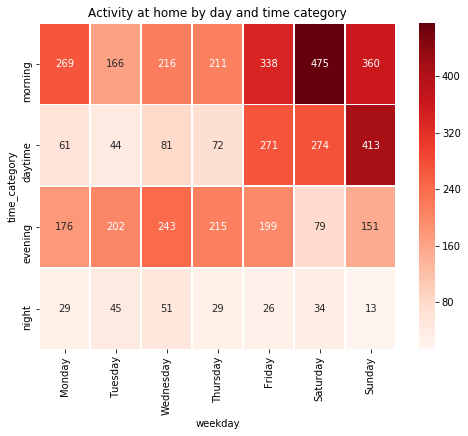

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))
days_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times_list = ['morning', 'daytime', 'evening', 'night']
ax = sns.heatmap(motion_df_gb[days_list].loc[times_list], annot=True, linewidths=.5, fmt="d", ax=ax, cmap='Reds');
ax.set_title('Activity at home by day and time category')
fig.savefig('heatmap.jpg')

## Bayesian sensor

In [51]:
query = 'entity == "binary_sensor.in_bed_bayesian"'
in_bed_bayes_df = df.query(query)
in_bed_bayes_df.head()

state
domain        entity                        numerical last_changed                    
binary_sensor binary_sensor.in_bed_bayesian False     2017-09-17 06:19:12.388015   off
                                                      2017-09-17 06:19:12.388015   off
                                                      2017-09-17 06:19:12.388015   off
                                                      2017-09-17 06:19:12.388015   off
                                                      2017-09-17 06:19:12.388015   off

In [52]:
in_bed_bayes_df['state'].unique()

array(['off'], dtype=object)

Hmm where are my on..

In [53]:
in_bed_bayes_df.index = in_bed_bayes_df.index.get_level_values('last_changed')  # Keep only last_changed level

In [54]:
in_bed_bayes_df.index = pd.to_datetime(in_bed_bayes_df.index)  # Convert to datetime

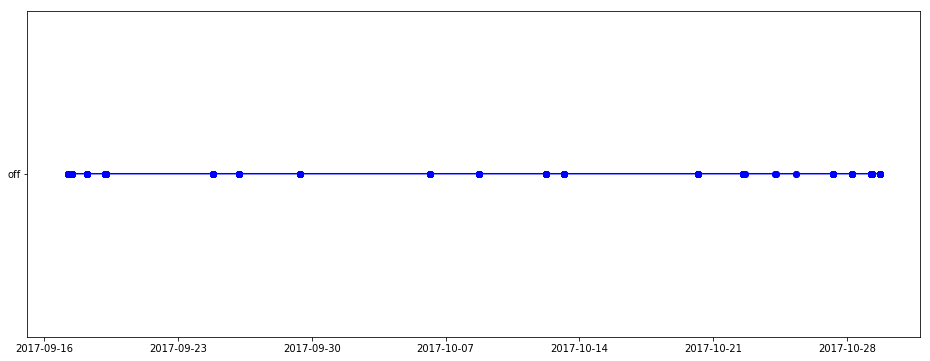

In [55]:
f, ax = plt.subplots(figsize=(16, 6))
ax.step(in_bed_bayes_df, 'bo', where='post')

Text(0,0.5,'In bed status')

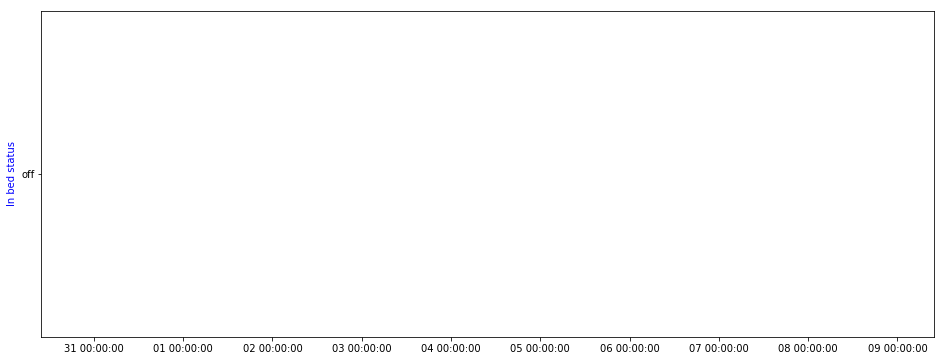

In [56]:
now = dt.datetime.now()
hours_to_plot = 240

f, ax = plt.subplots(figsize=(16, 6))
ax.step(in_bed_bayes_df, 'bo', where='post')
xfmt = md.DateFormatter('%d %H:%M:%S') # %m-
ax.xaxis.set_major_formatter(xfmt)
ax.set_xlim(now-dt.timedelta(hours=hours_to_plot), now)
ax.set_ylabel('In bed status', color='b')